Calculating distance from all populated census blocks in California (from 2010 census) to closest air pollution sensor

In [7]:
import geopandas as gpd
from geopandas import GeoSeries
from shapely.geometry import Polygon, MultiPolygon
import math
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import pandas as pd
import pymysql
import requests
import sqlite3
import zipfile
from pandas.io import sql
from sqlalchemy import create_engine
import shapely
from shapely.geometry import Polygon, Point
import time

# Loading census block population data

In [8]:
# Create empty list for non-populated blocks, which will be filtered by GEOID to get unique codes
nonpop_blocks = []
all_blocks = {}

# Get all county codes in CA: https://simple.wikipedia.org/wiki/List_of_counties_in_California
# 001 - 115 by odd nums
counties = list(map(str, np.arange(1, 117, 2)))
counties = list(map(lambda x: str.zfill(x, 3), counties))

# Get population data using the Census Decennial Summary File 1 (SF1) from 2010 because it goes down to block level
# ACS5 has more recent population data from 2018, but only goes down to block group level
# Find Decennial SF1 in 2010 at https://api.census.gov/data.html 
# California is state code 06
# Must use for loop over all counties because api doesn't allow iteration over all blocks at once 
for county_code in counties: 
    print(county_code)
    url = "https://api.census.gov/data/2010/dec/sf1?get=NAME,group(P1)&for=block:*&in=state:06%county:" + county_code
    r = requests.get(url)

    r.raise_for_status()
    
    data = r.json()

    blocks = pd.DataFrame(data)
    blocks.columns = blocks.iloc[0]
    blocks = blocks.iloc[1:]
    all_blocks[county_code] = blocks.copy()

    # Convert total population data to integers
    # P001001	Total	TOTAL POPULATION
    blocks['P001001'] = blocks['P001001'].apply(int)
    
    # Add block geoids where total population is 0 to the nonpopulated list
    nonpop_blocks.extend(blocks[blocks['P001001'] == 0]['GEO_ID'].values.tolist())

# Get rid of first '1000000US' of strings in geoid
nonpop_blocks = pd.Series(nonpop_blocks).apply(lambda x: x[9:])

001
003
005
007
009
011
013
015
017
019
021
023
025
027
029
031
033
035
037
039
041
043
045
047
049
051
053
055
057
059
061
063
065
067
069
071
073
075
077
079
081
083
085
087
089
091
093
095
097
099
101
103
105
107
109
111
113
115


In [9]:
#Concatenating information about all blocks in CA
blocks_df = pd.concat(all_blocks.values(), ignore_index=True)
blocks_df.head(1)

,NAME,GEO_ID,P001001,NAME,P001001ERR,state,county,tract,block
0,"Block 2007, Block Group 2, Census Tract 4077, ...",1000000US060014077002007,57,"Block 2007, Block Group 2, Census Tract 4077, ...",None,06,001,407700,2007


In [10]:
#Loading census block shapefile
block_shapes = gpd.read_file("tl_2010_06_tabblock10/tl_2010_06_tabblock10.shp")
block_shapes.head(1)

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,NAME10,MTFCC10,UR10,UACE10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,06,001,410000,2024,060014100002024,Block 2024,G5040,None,None,S,1180,0,+37.7514499,-122.1244488,"POLYGON ((-122.12489 37.75164, -122.12476 37.7..."


In [12]:
#Confirming block data and block shapefile data have same number of rows
assert block_shapes.shape[0] == blocks_df.shape[0]

In [13]:
#Filter out blocks with no population
block_shapes_pop = block_shapes[~block_shapes['GEOID10'].isin(nonpop_blocks)]

In [16]:
#Renaming block columns to be more tractable and to match with block shapefile column names
newcols = list(blocks_df.columns[:5])
newcols.extend(list(block_shapes_pop.columns[:4]))
blocks_df.columns = newcols

In [17]:
keycols = list(blocks_df.columns[5:])

In [27]:
gpd_block = block_shapes_pop.merge(blocks_df, how='left', on=keycols)
#gpd_block.to_file('CA_census_blocks_withPop.shp')

# Loading Airnow coordinates

In [28]:
airnow = gpd.read_file('airnow_ca_sensors.json')
airnow.head(3)

,index,SiteName,AgencyName,FullAQSCode,IntlAQSCode,geometry
0,0,Jacobs,North Coast Unified Air Quality Management Dis...,060231004,840060231004,POINT (-124.17750 40.77694)
1,5,Fort Bragg High School,Mendocino County AQMD,060450010,840060450010,POINT (-123.78766 39.43734)
2,6,Willits Justice Center,Mendocino County AQMD,060452002,840060452002,POINT (-123.35266 39.41174)


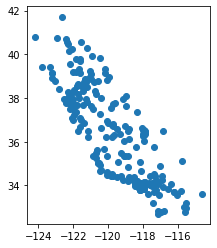

In [29]:
airnow.plot()

# Determining distribution of distance to nearest Airnow sensor

In [30]:
#Determining distance from centroid of each census block
block_centroids = gpd_block.copy()
block_centroids.geometry = gpd_block.geometry.apply(lambda x: x.centroid)

In [31]:
#Function to assign closest point from set B to each point in set A
#https://gis.stackexchange.com/questions/222315/geopandas-find-nearest-point-in-other-dataframe
from scipy.spatial import cKDTree
def ckdnearest(gdA, gdB):
    """Takes two geodataframes of point data. Determines closest point from
    set B to each point in set A. Dataframes should be reindexed before being passed
    to function to avoid errors"""
    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdf = pd.concat(
        [gdA.reset_index(drop=True), gdB.loc[idx, gdB.columns != 'geometry'].reset_index(drop=True),
         pd.Series(dist, name='dist')], axis=1)
    return gdf

In [32]:
#Aligning block CRS to airnow CRS
block_centroids = block_centroids.to_crs(airnow.crs)

In [33]:
#Finding nearest airnow sensor to each block centroid
block_centroids.reset_index(inplace=True, drop=True)
airnow.reset_index(inplace=True, drop=True)

nearestSensor = ckdnearest(block_centroids[['GEOID10','P001001','geometry']], 
           airnow[['SiteName','IntlAQSCode','geometry']])

In [34]:
#Merging with relevant columns of airnow data to get airnow geometry in addition to block geometry
nearestSensor = nearestSensor.merge(airnow[['IntlAQSCode','geometry']], how='left', on='IntlAQSCode')
nearestSensor.head(1)

,GEOID10,P001001,geometry_x,SiteName,IntlAQSCode,dist,geometry_y
0,060014053012002,132,POINT (-122.25435 37.80148),Laney College,840060010012,0.011969,POINT (-122.26338 37.79362)


In [35]:
#Creating a secondary geometry columns for the blocks (x) and the airnow sensors (y)
#compatible with geopy's great_circle distance function, used to calculate the distance
#between two points along the surface of the earth
nearestSensor['geom_x'] = nearestSensor.geometry_x.apply(lambda x: (x.xy[1][0], x.xy[0][0]))
nearestSensor['geom_y'] = nearestSensor.geometry_y.apply(lambda x: (x.xy[1][0], x.xy[0][0]))

In [36]:
#Calculating distance between each block centroid and its closest airnow sensor
from geopy import distance
dists = []
for block, sensor in zip(nearestSensor.geom_x, nearestSensor.geom_y):
    dists.append(distance.great_circle(block, sensor).miles)
    
nearestSensor['dist_mi'] = dists

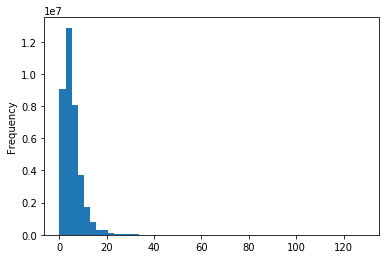

In [39]:
#Plotting histogram of distance, weighted by block population
nearestSensor.P001001 = nearestSensor.P001001.apply(lambda x: int(x))
nearestSensor["dist_mi"].plot(kind="hist", weights=nearestSensor["P001001"], bins=50)

In [40]:
nearestSensor.head(1)

,GEOID10,P001001,geometry_x,SiteName,IntlAQSCode,dist,geometry_y,geom_x,geom_y,dist_mi
0,060014053012002,132,POINT (-122.25435 37.80148),Laney College,840060010012,0.011969,POINT (-122.26338 37.79362),"(37.80148358865379, -122.25434888671525)","(37.793624, -122.263376)",0.733347


In [41]:
#Subsetting block gdf with full polygons (not centroids) to key columns and merging with 
#nearest sensor distance data
gpd_block_sub = gpd_block[['STATEFP10','COUNTYFP10','TRACTCE10','BLOCKCE10','GEOID10','P001001','geometry']]
output = gpd_block_sub.merge(nearestSensor[['SiteName','IntlAQSCode','dist_mi','GEOID10']], how='left', on='GEOID10')

In [148]:
#Saving full gdf including geometry
output.to_file('censusBlock_dist_nearestSensor.shp')

#Saving essential data to upload to GEE, to eventually merge w census block data already in GEE
to_gee = output[['GEOID10','dist_mi']]
to_gee.columns = ['blockid10','dist_mi']
to_gee.to_csv('dist_blockToSensor.csv', index=False)
to_gee.head()